# Q-Learning for a gridworld - ACDC2020


## Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import sys
import random
import numpy as np

from gym import spaces
from gym.core import Env
from gym.utils import seeding

In [0]:
working_dir = '/content/drive/My Drive/Colab Notebooks/ai-table/experiments/QL_for_simple_gridworld'
sys.path.append(working_dir)

In [0]:
import visutils
from mdp_meta_data import MdpMetaData
from plot_environment import PlotEnvironment

## Define environment and agent classes

### Environment class

In [0]:
class Environment(Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, n_rows=5, n_cols=5, inner_wall_coords=[[2,1],[2,2],[3,2],[4,2]], 
                 startX=3, startY=4, goalX=1, goalY=3):
        self.mdp_metadate = MdpMetaData(n_rows, n_cols, inner_wall_coords, 
                                        startX, startY, goalX, goalY)
        
        self.height = self.mdp_metadate.n_rows
        self.width = self.mdp_metadate.n_cols

        self.action_space = spaces.Discrete(self.mdp_metadate.num_actions)
        self.observation_space = spaces.Discrete(self.mdp_metadate.num_states)
        self.actions = self.mdp_metadate.actions
        
        self.start_state = self.mdp_metadate.start_state
        self.goal_state = self.mdp_metadate.goal_state
        
        self.inner_wall = self.mdp_metadate.inner_wall
        
        self.T, self.R, self.P = self.mdp_metadate.make_mdp()

        self.S = self.mdp_metadate.goal_state
        
        self.view = PlotEnvironment(self.mdp_metadate.n_rows, self.mdp_metadate.n_cols, 
                                    self.start_state, self.goal_state, self.mdp_metadate.inner_wall)
        
        self.seed()
        self.reset()
    
    def reset(self):
        # self.reset_frame_counter()
        self.S = self.start_state
        return self.S
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def move(self, action):
        # print('current s: ', self.S)
        # print('T', self.T.iloc[self.S, action])
        self.new_S = self.T.iloc[self.S, action]
        # print('new s: ', new_S)
        return self.new_S
    
    def step(self, action):
        self.old_S = self.S
        self.S = self.move(action)
        if self.S == self.goal_state:
            reward = 0
            return self.S, reward, True, {}
        else:
            reward = -1
            return self.S, reward, False, {}
    
    def render(self, mode='human'):
        self.metadata["render.frame_counter"] = self.view.plot_map(self.old_S, self.new_S)

### Agent class

In [0]:
#%%
class Random_Agent():
    def __init__(self, env):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.n
        
    def get_action(self, state):
        action = random.choice(range(self.action_size))
        return action
    
class QAgent(Random_Agent):
    def __init__(self, env, gamma=0.97, alpha=0.01, epsilon=1.0):
        super().__init__(env)
    
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        
        self.build_model()
    
    def build_model(self):
        self.q_table = 1e-4 * np.random.random([self.state_size, self.action_size])
        self.q_table[self.env.goal_state, :] = 0
        for w in self.env.inner_wall:
            self.q_table[w, :] = np.nan
        
    def get_action(self, state, policy='e_greedy'):
        q_state = self.q_table[state]
        if policy == 'e_greedy':
            action_greedy = np.argmax(q_state)
            action_random = random.choice(range(self.action_size))
            action = action_random if random.random() < self.epsilon else action_greedy
        return action
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        q_next = self.q_table[next_state] * (1 - done)
        q_max = np.max(q_next)
        q_target = reward + self.gamma * q_max
        q_update = q_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * q_update
        
        if done:
            self.epsilon = max(0.1, 0.998 * self.epsilon)

### Instantiating environment agent classes

In [0]:
env = Environment(default=5)

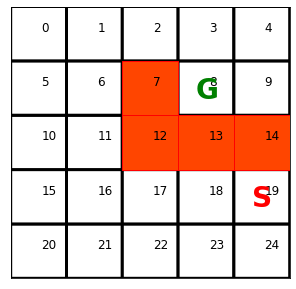

In [0]:
from plot_environment import PlotEnvironment
view = PlotEnvironment(env.height, env.width, env.start_state, env.goal_state, env.inner_wall)
view.show_image()

In [0]:
agent = QAgent(env) 

## Train Q-Learning Agent

In [0]:
def train_AQgent(env):
  total_reward = []
  view_freq = 500
  n_episodes = 2400
  obs_history = {ep:[] for ep in range(n_episodes)}
  for ep in range(n_episodes):
      if ep % view_freq == 0:
          print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          obs_history[ep].append(state)
          action = agent.get_action(state)
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          agent.train(experience)
          episode_reward.append(reward)        
          
          # experience_list = list(experience)
          # for str_a, int_a in env.actions.items():  
          #     if action == int_a:
          #         experience_list[1] = str_a
          # print('Experience: ', experience_list)
          
          # env.render()
          state = next_state
          
          if done:
              if ep % view_freq == 0:
                  print("Episode finished after {} timesteps".format(t))
                  print("Current epsilon is: ", agent.epsilon)
                  print('Episode Reward: {}'.format(np.sum(episode_reward)))
              break
      total_reward.append(np.sum(episode_reward))
  return env, agent, total_reward, obs_history

In [0]:
env, agent, total_reward, obs_history = train_AQgent(env)

---------- The episode number is:  0
Episode finished after 284 timesteps
Current epsilon is:  0.998
Episode Reward: -283
---------- The episode number is:  500
Episode finished after 25 timesteps
Current epsilon is:  0.36677623234744455
Episode Reward: -24
---------- The episode number is:  1000
Episode finished after 9 timesteps
Current epsilon is:  0.13479439340178997
Episode Reward: -8
---------- The episode number is:  1500
Episode finished after 13 timesteps
Current epsilon is:  0.1
Episode Reward: -12
---------- The episode number is:  2000
Episode finished after 10 timesteps
Current epsilon is:  0.1
Episode Reward: -9


#### Plot moving average reward 

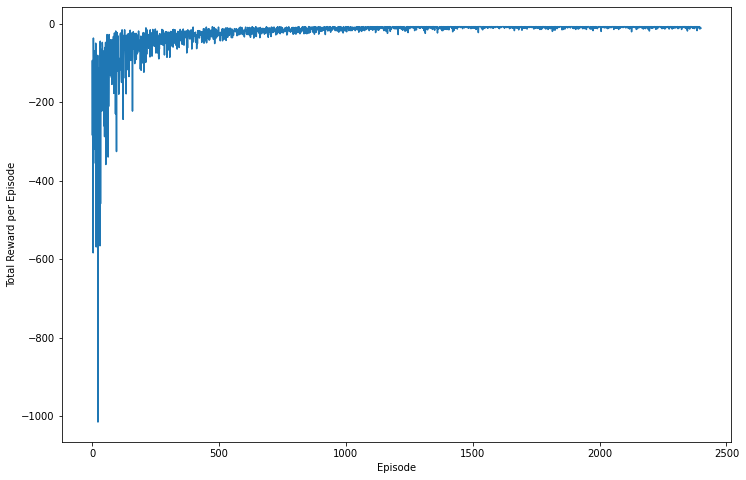

In [0]:
visutils.plot_reward(total_reward)

#### Check the agent performance in some episodes:

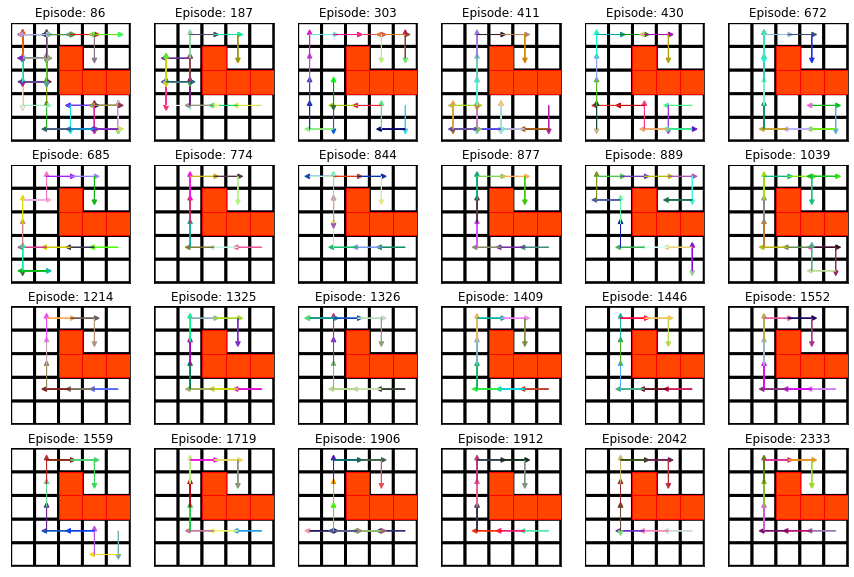

In [0]:
visutils.plot_obs_history(env, obs_history)

## Test Q-Learning Agent

In [0]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [0]:
pltdata = env.view

In [0]:
def render(t, cur_state, new_state):
    if t == 1:
        pltdata.fig, pltdata.ax = plt.subplots(figsize=(5,5))
        plt.xticks([])
        plt.yticks([])
        c = pltdata.ax.pcolor(pltdata.chessboard, edgecolors='k', linewidths=3, cmap='binary')

        for p in range(pltdata.bsize):
          pltdata.ax.text(pltdata.tp2cl(p)[1]+0.55, pltdata.tp2cl(p)[0]+0.55, str(p), fontsize=12)

        pltdata.ax.text(pltdata.p2c(pltdata.start_state)[1]+0.32, pltdata.p2c(pltdata.start_state)[0]+0.32, 'S', fontsize=28, color='red', fontweight='bold')
        pltdata.ax.text(pltdata.p2c(pltdata.goal_state)[1]+0.32, pltdata.p2c(pltdata.goal_state)[0]+0.32, 'G', fontsize=28, color='green', fontweight='bold')

        for t in range(pltdata.n_blocked_cells):    
            rect_xy = pltdata.wall_cell_coords[t]
            COLOR = pltdata.EVEN_COLOR if t % 2 == 0 else pltdata.ODD_COLOR 
            rect = patches.Rectangle((rect_xy[1]+pltdata.rect_shift_x, rect_xy[0]+pltdata.rect_shift_y), pltdata.rect_w, pltdata.rect_h, linewidth=1, edgecolor='r', facecolor=COLOR)
            pltdata.ax.add_patch(rect)

    
    arrow_start = np.array(pltdata.tp2cl(cur_state)) + 0.5
    arrow_stop = np.array(pltdata.tp2cl(new_state)) + 0.5
    diff = (arrow_stop[0] - arrow_start[0], arrow_stop[1] - arrow_start[1])
    COLOR = (np.random.rand(), np.random.rand(), np.random.rand())
    if not np.array_equal(arrow_start, arrow_stop):
        pltdata.ax.arrow(arrow_start[1], arrow_start[0], diff[1], diff[0], head_width=0.2, head_length=0.2, fc=COLOR, ec=COLOR)

    time.sleep(0.5)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [0]:
q_table = agent.q_table

In [0]:
def test_QAgent(env, q_table=q_table):
  total_reward = []
  n_episodes = 1
  for ep in range(n_episodes):
      print('========================================')
      print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          action = np.argmax(q_table[state])
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          # print('Experience: ', experience)
          episode_reward.append(reward)        

          agent.train(experience)
          render(t, state, next_state)
          
          state = next_state

          if done:
              print("Episode finished after {} timesteps".format(t))
              break

      total_reward.append(np.sum(episode_reward))
      print('Episode Reward: {}'.format(np.sum(episode_reward)))

Episode finished after 9 timesteps
Episode Reward: -8


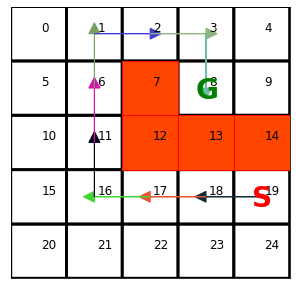

In [0]:
test_QAgent(env, q_table)

# Assignment

### There is a 10*10 table in the mdp_meta_data.py. The following figure show this table. 
* Your task is to train the Q-learning to find the best policy by:
  * changing Q-Learning hyperparamers
  * changing the training parameters like the number of episodes
  * modifying reward

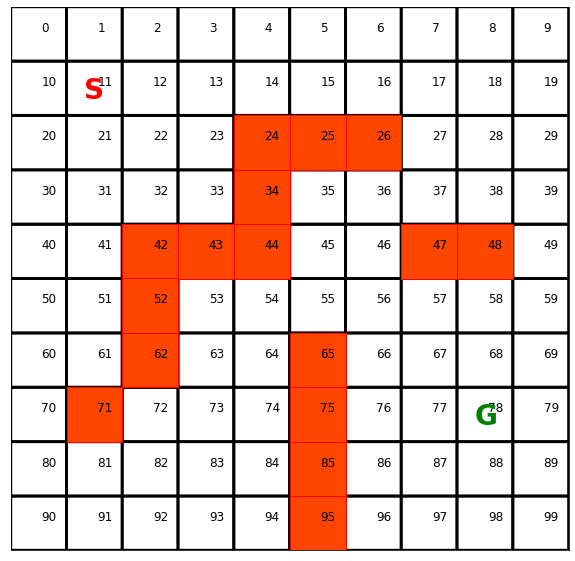

In [0]:
from grid_world_general_env import Environment
from plot_environment import PlotEnvironment
env = Environment(default=10)
view = PlotEnvironment(env.height, env.width, env.start_state, env.goal_state, env.inner_wall)
view.show_image()

## Define a new environment

In [0]:
# [1,2]=[row, column]
# startX=>startRow, startY=>startColumn
env = Environment(default=None, n_rows=8, n_cols=8, 
                  inner_wall_coords=[[1,2],[1,3],[1,4],[1,5],[2,2],[3,2],[3,3],[3,4],[3,5],[5,2],[5,3],[5,4],[6,4], [7,2],[7,3],[7,4]], 
                  startX=6, startY=3, goalX=2, goalY=3)

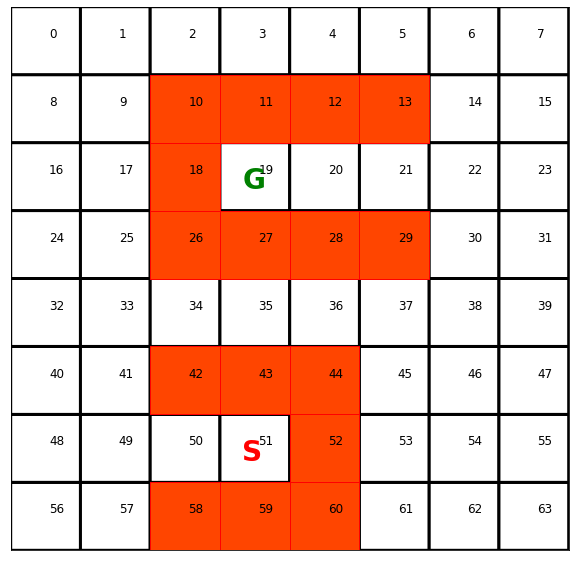

In [0]:
view = PlotEnvironment(env.height, env.width, env.start_state, env.goal_state, env.inner_wall)
view.show_image()